# CIFAR-10 Baseline model

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.layers import BatchNormalization

# importing of service libraries
import numpy as np
import matplotlib.pyplot as plt

print('Libraries imported.')

2023-04-13 23:54:00.557717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported.


#### Random seed

In [2]:
import random
import tensorflow as tf
import os


def set_seed(seed=42):
    '''
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

## Data preprocessing

#### Data Load

In [3]:
from tensorflow.keras.datasets import cifar10
(input_X_train, output_y_train),(input_X_test, output_y_test)=cifar10.load_data()

print('input_X_train shape: ', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')

input_X_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMAGE_SIZE = input_X_train.shape[1]

print('Image variables initialisation')

Image variables initialisation


In [5]:
N_CLASSES =len(np.unique(output_y_train))

In [8]:
N_CLASSES

10

#### Distribution of each class

Text(0.5, 1.0, 'Class distribution in training set')

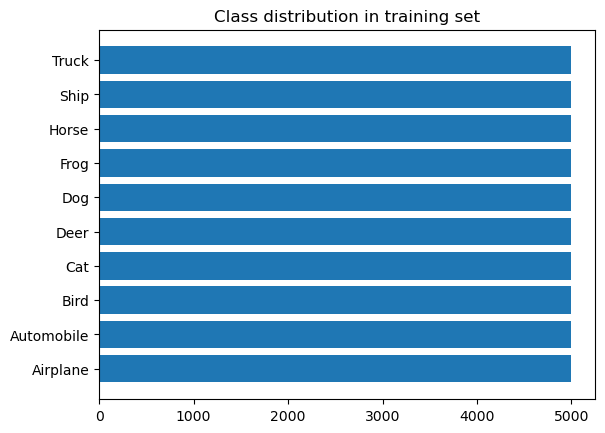

In [50]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(output_y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')


Text(0.5, 1.0, 'Class distribution in testing set')

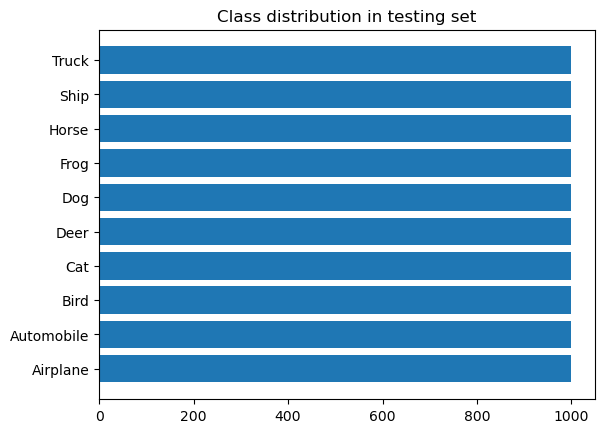

In [51]:
classes, counts = np.unique(output_y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

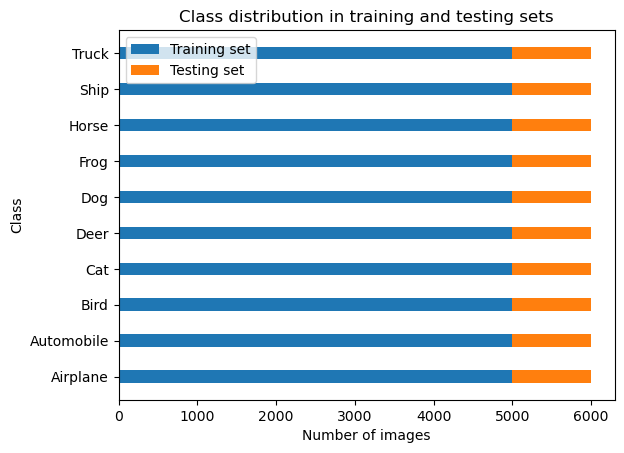

In [52]:
# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Count class frequencies in training and testing sets
train_classes, train_counts = np.unique(output_y_train, return_counts=True)
test_classes, test_counts = np.unique(output_y_test, return_counts=True)

# Set bar width
bar_width = 0.35

# Plot grouped bar chart
fig, ax = plt.subplots()
ax.barh(class_names, train_counts, bar_width, label='Training set')
ax.barh(class_names, test_counts, bar_width, left=train_counts, label='Testing set')

# Set axis labels and title
ax.set_xlabel('Number of images')
ax.set_ylabel('Class')
ax.set_title('Class distribution in training and testing sets')

# Add legend and show plot
ax.legend()
plt.show()


#### Data preprocessing

In [6]:
# output data one-hot encoding 
output_y_train=utils.to_categorical(output_y_train, N_CLASSES)
output_y_test=utils.to_categorical(output_y_test, N_CLASSES)

In [7]:
# To normalize the value in between 0 and 1 (there are 255 kinds)
input_X_train=input_X_train.astype('float32')
input_X_test=input_X_test.astype('float32')

input_X_train /=255
input_X_test /=255

#### Data visualization

/Users/jeongdahye/opt/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


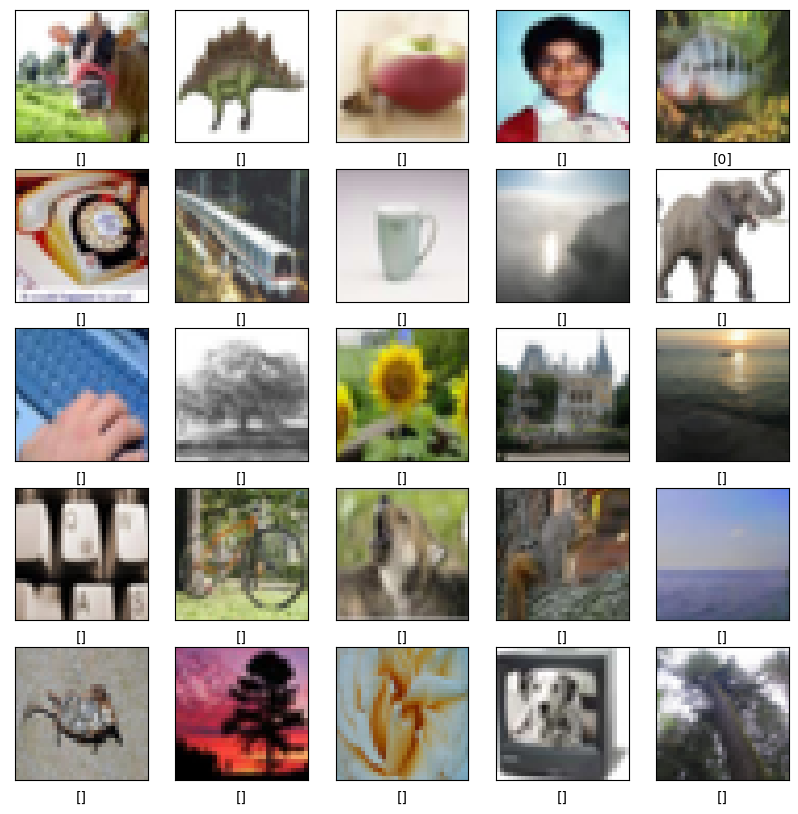

In [7]:
plt.figure(figsize=(10,10)) 

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(input_X_train[i], cmap="gray")
  plt.xlabel(np.where(output_y_train[i] == 1)[0])

plt.show()


#### Pre-defined function for plotting history

In [9]:
#Define the function for plotting the history of the training of the model
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

#### Earlystopping

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# define early stopping callback
earlystop_callback = EarlyStopping(
    monitor='val_loss', # monitor validation loss
    min_delta=0.001, # minimum change in the monitored quantity to qualify as an improvement
    patience=5, # number of epochs with no improvement after which training will be stopped
    verbose=1 # prints a message when early stopping is triggered
)

# Hyper parameter Trial 1

In [12]:
#training constants
BATCH_SIZE1 = 128
N_EPOCH1 = 20 # use 20 for best initial results
VERBOSE1 = 1
VALIDATION_SPLIT1 = 0.2
learning_rate1 = 0.01
OPTIM1 = RMSprop(learning_rate = learning_rate1)
KERNEL = (3,3)

print('Main variables initialised.')

Main variables initialised.


Pure simple model(less complexity) without data augementation returned 46% accuracy. 

## Trial 2

In [13]:
#training constants
BATCH_SIZE1 = 128
N_EPOCH2 = 30 
VERBOSE1 = 1
VALIDATION_SPLIT1 = 0.2
learning_rate1 = 0.01
OPTIM1 = RMSprop(learning_rate = learning_rate1)
KERNEL = (5,5)

print('Main variables initialised.')

Main variables initialised.


Epochs increased to 30, but Result is too bad. Need to improve the other parameters.

## Trial 3

In [14]:
#training constants
BATCH_SIZE1 = 128
N_EPOCH3 = 50 # use 20 for best initial results
VERBOSE1 = 1
VALIDATION_SPLIT1 = 0.2
learning_rate1 = 0.01
OPTIM3 = Adam(learning_rate = learning_rate1)
KERNEL = (3,3)

print('Main variables initialised.')

Main variables initialised.


Optimizer is Adam, Epochs increased to 50. But no performance improvement. 

## Trial 4

In [15]:
#training constants
BATCH_SIZE1 = 128
N_EPOCH3 = 50 # use 20 for best initial results
VERBOSE1 = 1
VALIDATION_SPLIT1 = 0.2
learning_rate4 = 0.001
OPTIM3 = Adam(learning_rate = learning_rate4)
KERNEL = (3,3)

print('Main variables initialised.')

Main variables initialised.


learning rate decreased to 0.001

## Trial 5

In [11]:
#training constants
BATCH_SIZE1 = 128
N_EPOCH2 = 30 # use 20 for best initial results
VERBOSE1 = 1
VALIDATION_SPLIT5 = 0.1
learning_rate5 = 0.0001
OPTIM = Adam(learning_rate = learning_rate5)
KERNEL = (3,3)

print('Main variables initialised.')

Main variables initialised.


Learning rate reduced, validation_split reduced, epoch reduced

# Model Building

In [ ]:
#training constants
BATCH_SIZE = 128
N_EPOCH = 50
VERBOSE = 1
VALIDATION_SPLIT = 0.2
learning_rate = 0.0001
OPTIM = Adam(learning_rate = learning_rate)
KERNEL = (3,3)

print('Main variables initialised.')

### Simple Model

In [12]:
from tensorflow.keras.datasets import cifar10
(input_X_train, output_y_train),(input_X_test, output_y_test)=cifar10.load_data()

print('input_X_train shape: ', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')

# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMAGE_SIZE = input_X_train.shape[1]

print('Image variables initialisation')

N_CLASSES =len(np.unique(output_y_train))

# output data one-hot encoding 
output_y_train=utils.to_categorical(output_y_train, N_CLASSES)
output_y_test=utils.to_categorical(output_y_test, N_CLASSES)

# To normalize the value in between 0 and 1 (there are 255 kinds)
input_X_train=input_X_train.astype('float32')
input_X_test=input_X_test.astype('float32')

input_X_train /=255
input_X_test /=255

#Simpler Model

model=Sequential()

# layer 1 
model.add(Conv2D(32, (3,3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

print('CNN Network Definition setup')



CNN Network Definition setup


#### Without Data Augmentation

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                      

Epoch 1/50
157/157 [==============================] - 85s 534ms/step - loss: 1.9429 - accuracy: 0.3050 - val_loss: 1.6749 - val_accuracy: 0.4260
Epoch 2/50
157/157 [==============================] - 77s 492ms/step - loss: 1.6234 - accuracy: 0.4296 - val_loss: 1.5096 - val_accuracy: 0.4871
Epoch 3/50
157/157 [==============================] - 79s 504ms/step - loss: 1.4967 - accuracy: 0.4740 - val_loss: 1.4269 - val_accuracy: 0.5099
Epoch 4/50
157/157 [==============================] - 66s 420ms/step - loss: 1.4178 - accuracy: 0.4978 - val_loss: 1.3690 - val_accuracy: 0.5289
Epoch 5/50
157/157 [==============================] - 62s 393ms/step - loss: 1.3614 - accuracy: 0.5187 - val_loss: 1.3395 - val_accuracy: 0.5376
Epoch 6/50
157/157 [==============================] - 76s 483ms/step - loss: 1.3222 - accuracy: 0.5327 - val_loss: 1.2908 - val_accuracy: 0.5552
Epoch 7/50
157/157 [==============================] - 66s 417ms/step - loss: 1.2850 - accuracy: 0.5494 - val_loss: 1.2639 - val_ac

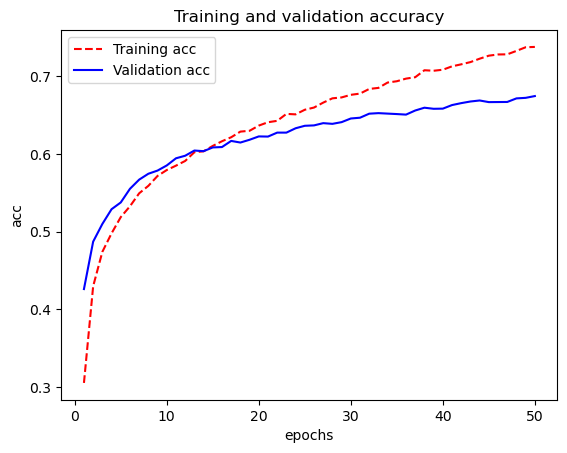

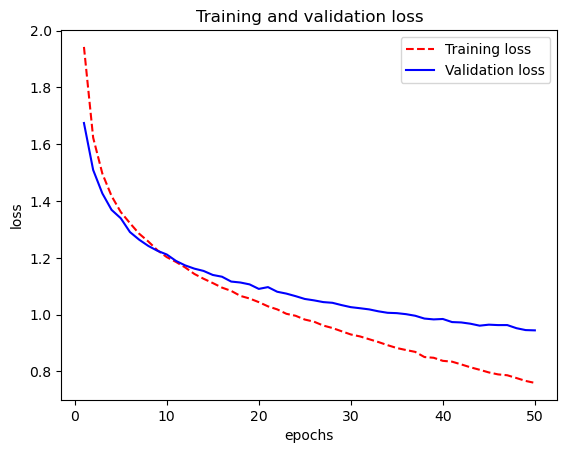

<Figure size 640x480 with 0 Axes>

In [14]:
history = model.fit(input_X_train, output_y_train, 
                    batch_size=256, epochs=50, validation_split=0.2, 
                    verbose=1, callbacks=[earlystop_callback])

# We can save our model with:
model.save('model_simple.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model_simple.h5')


In [ ]:

plot_history(history)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

plot_history(history_vit)
test_acc_simple = model.evaluate(input_X_test, output_y_test, verbose=2)
print("test accuracy: ", test_acc_simple)

#### With Data Augmentation

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                      

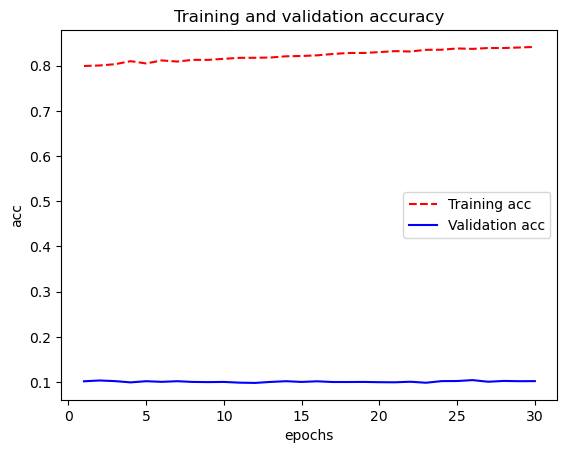

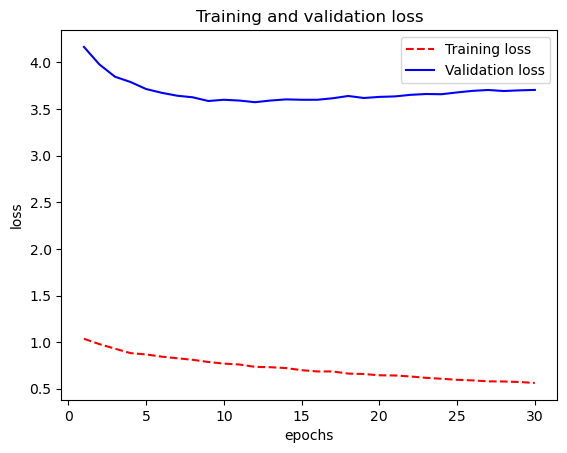

<Figure size 640x480 with 0 Axes>

In [24]:
from tensorflow.keras.datasets import cifar10
(input_X_train, output_y_train),(input_X_test, output_y_test)=cifar10.load_data()

print('input_X_train shape: ', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')

# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMAGE_SIZE = input_X_train.shape[1]

print('Image variables initialisation')

N_CLASSES =len(np.unique(output_y_train))

# output data one-hot encoding 
output_y_train=utils.to_categorical(output_y_train, N_CLASSES)
output_y_test=utils.to_categorical(output_y_test, N_CLASSES)

# To normalize the value in between 0 and 1 (there are 255 kinds)
input_X_train=input_X_train.astype('float32')
input_X_test=input_X_test.astype('float32')

input_X_train /=255
input_X_test /=255

#Simpler Model

model=Sequential()

# layer 1 
model.add(Conv2D(32, (3,3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

print('CNN Network Definition setup')

# Result with data augmentation
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(input_X_train, output_y_train, batch_size)
steps_per_epoch = input_X_train.shape[0] // batch_size

history=model.fit(train_generator, batch_size=512, 
                  epochs=50, validation_split=0.2, steps_per_epoch=steps_per_epoch, verbose=VERBOSE1, callbacks=[earlystop_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

plot_history(history_vit)
test_acc_simple_aug = model.evaluate(input_X_test, output_y_test, verbose=2)
print("test accuracy: ", test_acc_simple_aug)

### Complex CNN

In [16]:
from tensorflow.keras.datasets import cifar10
(input_X_train, output_y_train),(input_X_test, output_y_test)=cifar10.load_data()

print('input_X_train shape: ', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')

# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMAGE_SIZE = input_X_train.shape[1]

print('Image variables initialisation')

N_CLASSES =len(np.unique(output_y_train))

# output data one-hot encoding 
output_y_train=utils.to_categorical(output_y_train, N_CLASSES)
output_y_test=utils.to_categorical(output_y_test, N_CLASSES)

# To normalize the value in between 0 and 1 (there are 255 kinds)
input_X_train=input_X_train.astype('float32')
input_X_test=input_X_test.astype('float32')

input_X_train /=255
input_X_test /=255

from keras.layers import BatchNormalization
# Complex DNN model definition
model = Sequential()

# hidden 1 : conv + conv + pool + dropout 
model.add(Conv2D(32, (3,3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

# hidden 2 : conv + conv + pool + dropout 
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
 
# hidden 3 : flatten + droupout 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output 
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

# Result without data augmentation
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

#### Without data augmentation

In [17]:
# Result without data augmentation
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_3 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 32)        0         
                                                      

Epoch 1/50
157/157 [==============================] - 203s 1s/step - loss: 2.4063 - accuracy: 0.1705 - val_loss: 2.3904 - val_accuracy: 0.0998
Epoch 2/50
157/157 [==============================] - 210s 1s/step - loss: 2.0607 - accuracy: 0.2583 - val_loss: 2.3577 - val_accuracy: 0.1087
Epoch 3/50
157/157 [==============================] - 238s 2s/step - loss: 1.8885 - accuracy: 0.3069 - val_loss: 1.9383 - val_accuracy: 0.2495
Epoch 4/50
157/157 [==============================] - 156s 993ms/step - loss: 1.7831 - accuracy: 0.3400 - val_loss: 1.6622 - val_accuracy: 0.3809
Epoch 5/50
157/157 [==============================] - 170s 1s/step - loss: 1.7041 - accuracy: 0.3680 - val_loss: 1.5424 - val_accuracy: 0.4295
Epoch 6/50
157/157 [==============================] - 152s 972ms/step - loss: 1.6452 - accuracy: 0.3894 - val_loss: 1.4902 - val_accuracy: 0.4511
Epoch 7/50
157/157 [==============================] - 202s 1s/step - loss: 1.5984 - accuracy: 0.4108 - val_loss: 1.4471 - val_accuracy: 

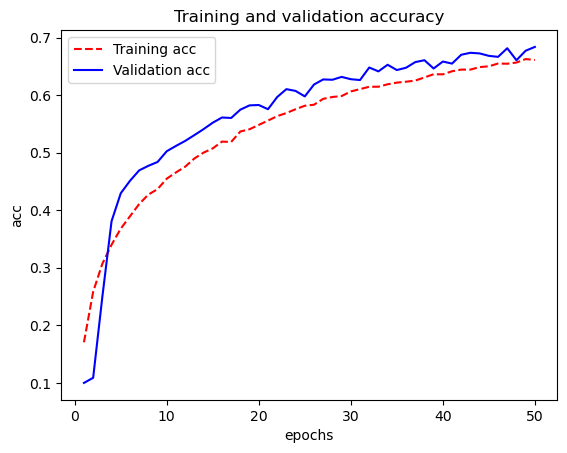

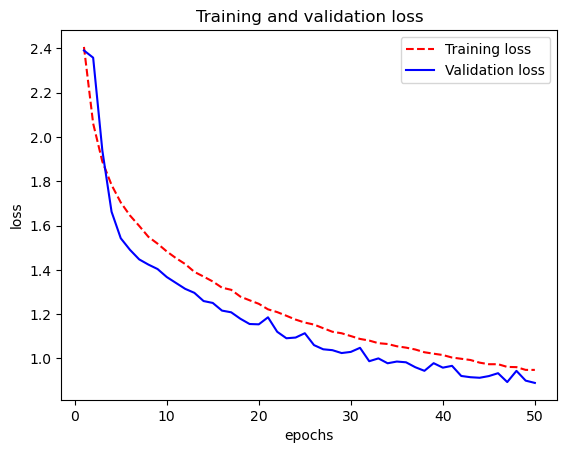

<Figure size 640x480 with 0 Axes>

In [19]:
history=model.fit(input_X_train, output_y_train, batch_size=256, 
                  epochs=50, validation_split=0.2, verbose=1)

# We can save our model with:
model.save('model_complex.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model_complex.h5')

In [ ]:
plot_history(history)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

plot_history(history_vit)
test_acc_complex = model.evaluate(input_X_test, output_y_test, verbose=2)
print("test accuracy: ", test_acc_complex)

#### With data augmentation

In [31]:
from tensorflow.keras.datasets import cifar10
(input_X_train, output_y_train),(input_X_test, output_y_test)=cifar10.load_data()

print('input_X_train shape: ', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')

# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMAGE_SIZE = input_X_train.shape[1]

print('Image variables initialisation')

N_CLASSES =len(np.unique(output_y_train))

# output data one-hot encoding 
output_y_train=utils.to_categorical(output_y_train, N_CLASSES)
output_y_test=utils.to_categorical(output_y_test, N_CLASSES)

# To normalize the value in between 0 and 1 (there are 255 kinds)
input_X_train=input_X_train.astype('float32')
input_X_test=input_X_test.astype('float32')

input_X_train /=255
input_X_test /=255

from keras.layers import BatchNormalization
# Complex DNN model definition
model = Sequential()

# hidden 1 : conv + conv + pool + dropout 
model.add(Conv2D(32, (3,3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

# hidden 2 : conv + conv + pool + dropout 
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
 
# hidden 3 : flatten + droupout 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output 
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

# Result with data augmentation
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                      

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(input_X_train, output_y_train, batch_size)
steps_per_epoch = input_X_train.shape[0] // batch_size

history=model.fit(train_generator, batch_size=512, 
                  epochs=50, validation_split=0.2, steps_per_epoch=steps_per_epoch, verbose=VERBOSE1, callbacks=[earlystop_callback])

Epoch 1/50
79/79 [==============================] - 194s 2s/step - loss: 5.0275 - accuracy: 0.0108 - val_loss: 4.6108 - val_accuracy: 0.0098
Epoch 2/50
79/79 [==============================] - 131s 2s/step - loss: 4.9183 - accuracy: 0.0097 - val_loss: 4.6175 - val_accuracy: 0.0101
Epoch 3/50
79/79 [==============================] - 123s 2s/step - loss: 4.8159 - accuracy: 0.0099 - val_loss: 4.6198 - val_accuracy: 0.0074
Epoch 4/50
79/79 [==============================] - 124s 2s/step - loss: 4.7496 - accuracy: 0.0103 - val_loss: 4.6174 - val_accuracy: 0.0079
Epoch 5/50
79/79 [==============================] - 127s 2s/step - loss: 4.6926 - accuracy: 0.0101 - val_loss: 4.6121 - val_accuracy: 0.0093
Epoch 6/50
79/79 [==============================] - 162s 2s/step - loss: 4.6596 - accuracy: 0.0101 - val_loss: 4.6093 - val_accuracy: 0.0104
Epoch 7/50
79/79 [==============================] - 122s 2s/step - loss: 4.6401 - accuracy: 0.0106 - val_loss: 4.6074 - val_accuracy: 0.0087
Epoch 8/50
79

313/313 - 16s - loss: 4.6052 - accuracy: 0.0094 - 16s/epoch - 52ms/step
test accuracy:  0.009399999864399433


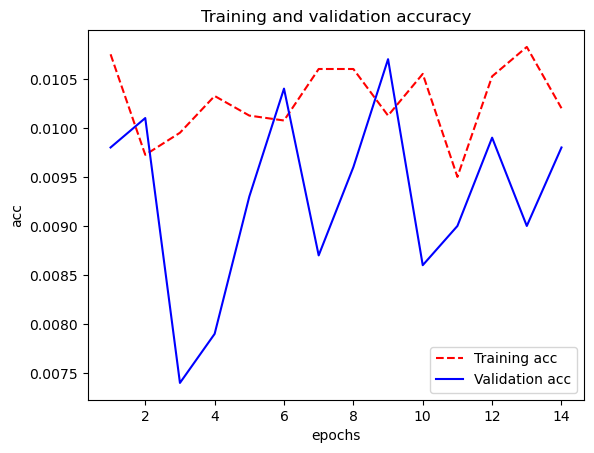

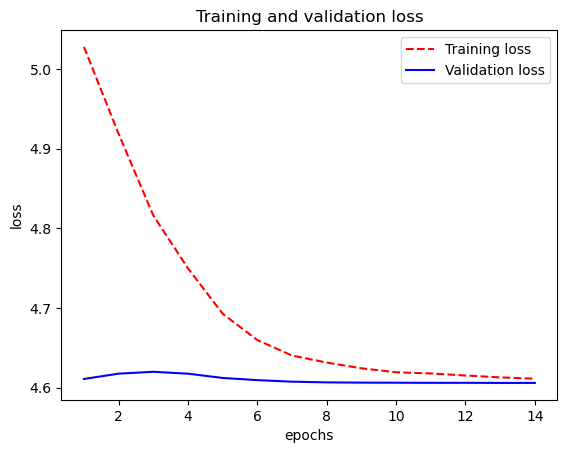

<Figure size 640x480 with 0 Axes>

In [33]:
plot_history(history)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

plot_history(history_vit)
test_acc_complex_aug = model.evaluate(input_X_test, output_y_test, verbose=2)
print("test accuracy: ", test_acc_complex_aug)

### New Complex

In [12]:
KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (32, 32, 3)

model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))


METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
model.summary()

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                      

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(input_X_train, output_y_train, batch_size)
steps_per_epoch = input_X_train.shape[0] // batch_size

history_new_complex = model.fit(train_generator, 
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(input_X_test, output_y_test), 
               callbacks=[earlystop_callback],
               batch_size=batch_size,
             )

Epoch 1/50
1562/1562 [==============================] - 736s 468ms/step - loss: 1.6053 - accuracy: 0.4214 - val_loss: 1.3248 - val_accuracy: 0.5276
Epoch 2/50
1562/1562 [==============================] - 755s 483ms/step - loss: 1.2076 - accuracy: 0.5752 - val_loss: 1.0216 - val_accuracy: 0.6361
Epoch 3/50
1562/1562 [==============================] - 825s 528ms/step - loss: 1.0331 - accuracy: 0.6394 - val_loss: 1.0981 - val_accuracy: 0.6329
Epoch 4/50
1562/1562 [==============================] - 810s 519ms/step - loss: 0.9304 - accuracy: 0.6811 - val_loss: 0.8888 - val_accuracy: 0.7015
Epoch 5/50
1562/1562 [==============================] - 732s 468ms/step - loss: 0.8613 - accuracy: 0.7046 - val_loss: 0.8722 - val_accuracy: 0.6987
Epoch 6/50
1562/1562 [==============================] - 746s 478ms/step - loss: 0.8059 - accuracy: 0.7257 - val_loss: 0.8530 - val_accuracy: 0.7271
Epoch 7/50
1562/1562 [==============================] - 762s 488ms/step - loss: 0.7544 - accuracy: 0.7416 - val_

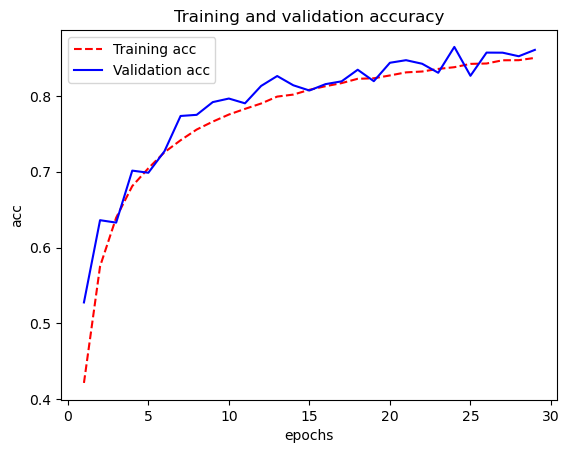

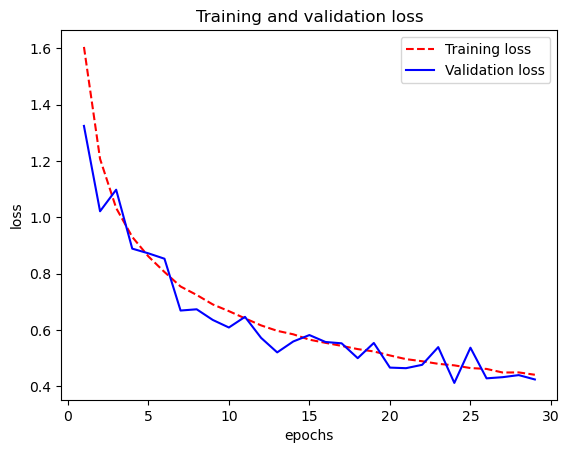

<Figure size 640x480 with 0 Axes>

In [17]:
plot_history(history_new_complex)

test_acc_new_complex = model.evaluate(input_X_test, output_y_test, verbose=2)
print("test accuracy: ", test_acc_new_complex)

print("test accuracy: ", test_acc_new_complex[1])

313/313 - 30s - loss: 0.4242 - accuracy: 0.8608 - 30s/epoch - 97ms/step
test accuracy:  [0.42419034242630005, 0.86080002784729]


In [ ]:
# We can save our model with:
model.save('model_complex2.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model_complex2.h5')

## TL - VGG16

In [20]:
from keras.applications import VGG16
from keras.datasets import cifar10
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Load pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze pre-trained layers
for layer in vgg16.layers:
    layer.trainable = False

# Add new classification layers
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size


# Train model
history_vgg = model.fit(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=N_epochs, batch_size=64, callbacks=[earlystop_callback])


Epoch 1/10
782/782 [==============================] - 1279s 2s/step - loss: 1.3716 - accuracy: 0.5225 - val_loss: 1.2486 - val_accuracy: 0.5625
Epoch 2/10
782/782 [==============================] - 1160s 1s/step - loss: 1.1866 - accuracy: 0.5857 - val_loss: 1.1873 - val_accuracy: 0.5890
Epoch 3/10
782/782 [==============================] - 978s 1s/step - loss: 1.1228 - accuracy: 0.6067 - val_loss: 1.1595 - val_accuracy: 0.5991
Epoch 4/10
782/782 [==============================] - 986s 1s/step - loss: 1.0801 - accuracy: 0.6221 - val_loss: 1.1591 - val_accuracy: 0.5946
Epoch 5/10
782/782 [==============================] - 1058s 1s/step - loss: 1.0419 - accuracy: 0.6350 - val_loss: 1.1558 - val_accuracy: 0.5946
Epoch 6/10
782/782 [==============================] - 1107s 1s/step - loss: 1.0084 - accuracy: 0.6480 - val_loss: 1.1314 - val_accuracy: 0.6062
Epoch 7/10
782/782 [==============================] - 1175s 2s/step - loss: 0.9757 - accuracy: 0.6589 - val_loss: 1.1054 - val_accuracy: 0

/var/folders/0x/n51_7s_n09dfndljqk4rv2zr0000gn/T/ipykernel_52039/2659796893.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


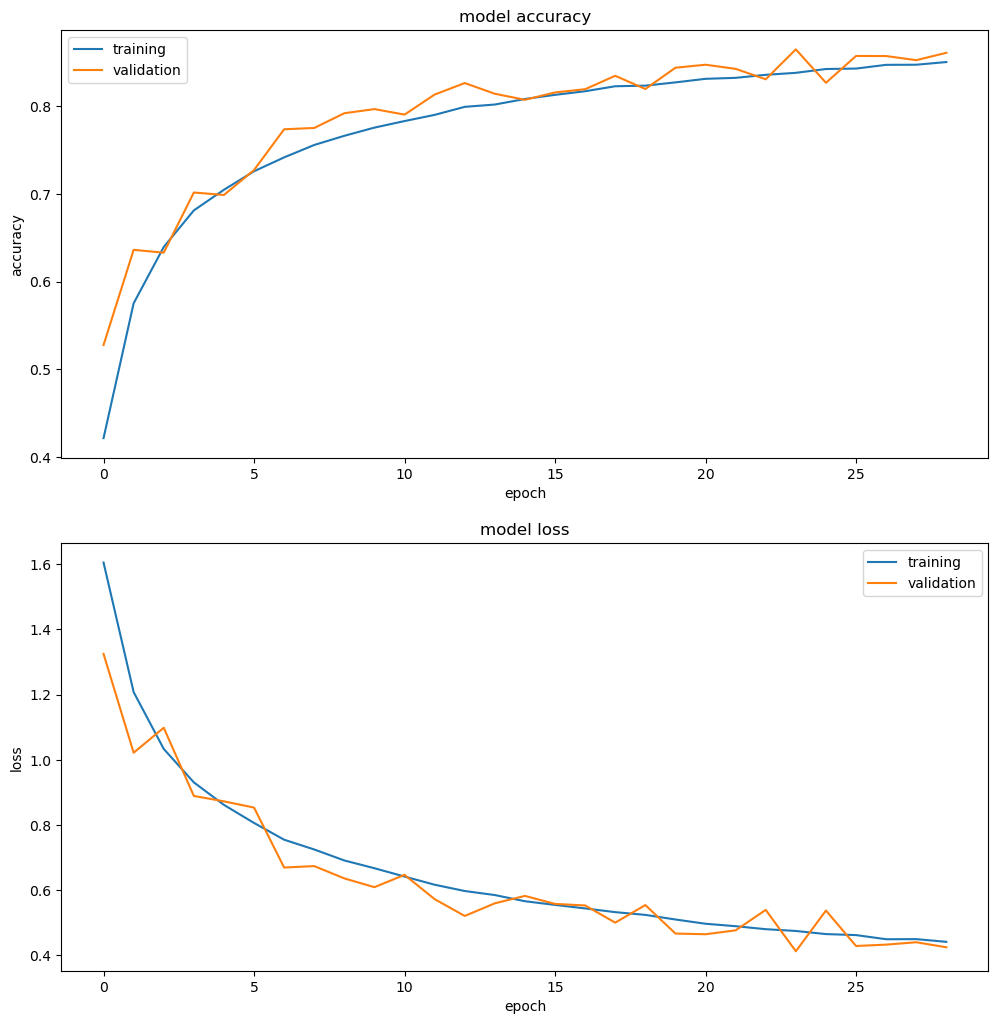

In [24]:
model.summary()

final_accuracy = history_vgg.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

plot_history(history_vgg)
test_acc_vgg16 = model.evaluate(x_test, y_test, verbose=2)
print("test accuracy: ", test_acc_vgg16)

In [ ]:
# We can save our model with:
model.save('model_vgg.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model_vgg.h5')

## TL - EfficientNetB0

In [25]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

# CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# EfficientNetB0 모델 로드
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32,32,3))

# 새로운 분류 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# 새로운 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# EfficientNetB0 모델의 가중치는 고정하고, 새로운 분류 레이어의 가중치만 학습
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

# 모델 학습
history_eb=model.fit(x_train, y_train, epochs=N_epochs, batch_size=32,steps_per_epoch=steps_per_epoch, validation_data=(x_test, y_test), callbacks=[earlystop_callback])


Epoch 1/10
1563/1563 [==============================] - 280s 171ms/step - loss: 1.4112 - accuracy: 0.4926 - val_loss: 1.2436 - val_accuracy: 0.5518
Epoch 2/10
1563/1563 [==============================] - 285s 183ms/step - loss: 1.2617 - accuracy: 0.5467 - val_loss: 1.2576 - val_accuracy: 0.5535
Epoch 3/10
1563/1563 [==============================] - 277s 177ms/step - loss: 1.2192 - accuracy: 0.5611 - val_loss: 1.1693 - val_accuracy: 0.5758
Epoch 4/10
1563/1563 [==============================] - 275s 176ms/step - loss: 1.1780 - accuracy: 0.5775 - val_loss: 1.1493 - val_accuracy: 0.5856
Epoch 5/10
1563/1563 [==============================] - 259s 166ms/step - loss: 1.1510 - accuracy: 0.5847 - val_loss: 1.1652 - val_accuracy: 0.5914
Epoch 6/10
1563/1563 [==============================] - 269s 172ms/step - loss: 1.1377 - accuracy: 0.5941 - val_loss: 1.1496 - val_accuracy: 0.5890
Epoch 7/10
1563/1563 [==============================] - 299s 192ms/step - loss: 1.1175 - accuracy: 0.6001 - val_

In [ ]:
model.summary()

final_accuracy = history_eb.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

plot_history(history_eb)
test_acc_eb = model.evaluate(x_test, y_test, verbose=2)
print("test accuracy: ", test_acc_eb)

In [ ]:
# We can save our model with:
model.save('model_eb.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model_eb.h5')

## TL - BiT

In [27]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetB7

# CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# 데이터 전처리
x_train = keras.applications.efficientnet.preprocess_input(x_train)
x_test = keras.applications.efficientnet.preprocess_input(x_test)

# BiT 모델 로드
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 새로운 분류 레이어 추가
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
predictions = keras.layers.Dense(10, activation='softmax')(x)

# 전이 학습 모델 생성
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

# 모델 학습
history_vit=model.fit(x_train, y_train, epochs=N_epochs, steps_per_epoch=steps_per_epoch, validation_data=(x_test, y_test), callbacks=[earlystop_callback])


258076736/258076736 [==============================] - 22s 0us/step
Epoch 1/10
1369/1563 [=========================>....] - ETA: 14:45 - loss: 1.1356 - accuracy: 0.6175

KeyboardInterrupt: 

In [ ]:
model.summary()

final_accuracy = history_vit.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

plot_history(history_vit)
test_acc_vit = model.evaluate(x_test, y_test, verbose=2)
print("test accuracy: ", test_acc_vit)

In [ ]:
# We can save our model with:
model.save('model_vit.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model_vit.h5')

# Result

In [ ]:
test_acc_vit, test_acc_vgg, test_acc_eb, test_acc_new_complex, test_acc_complex, test_acc_complex_aug, test_acc_simple, test_acc_simple_aug

BiT(Big Transfer)은 Google에서 공개한 대규모 이미지 분류 모델입니다. BiT 모델은 ImageNet 데이터셋으로 학습된 모델을 기반으로 하며, 다양한 크기와 해상도의 이미지를 처리할 수 있습니다.


EfficientNetB7는 BiT 모델 중 하나로, ImageNet 데이터셋에서 학습된 모델입니다. EfficientNetB7는 7개의 레이어로 이루어져 있으며, 총 파라미터 수는 66M 정도입니다. 이 모델은 다양한 크기와 해상도의 이미지를 처리할 수 있어서, CIFAR-10 데이터셋과 같은 작은 데이터셋에서도 좋은 성능을 보입니다.


위 코드에서는 EfficientNetB7 모델을 사용하여 CIFAR-10 데이터셋으로 전이 학습을 수행합니다. EfficientNetB7 모델은 include_top=False로 설정하여 분류 레이어를 제외하고 로드합니다. 이후 새로운 분류 레이어를 추가하고 전이 학습 모델을 생성합니다.